1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-life $\tau$ of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

Text(0.5, 1.0, 'Histogram of the random number distribution')

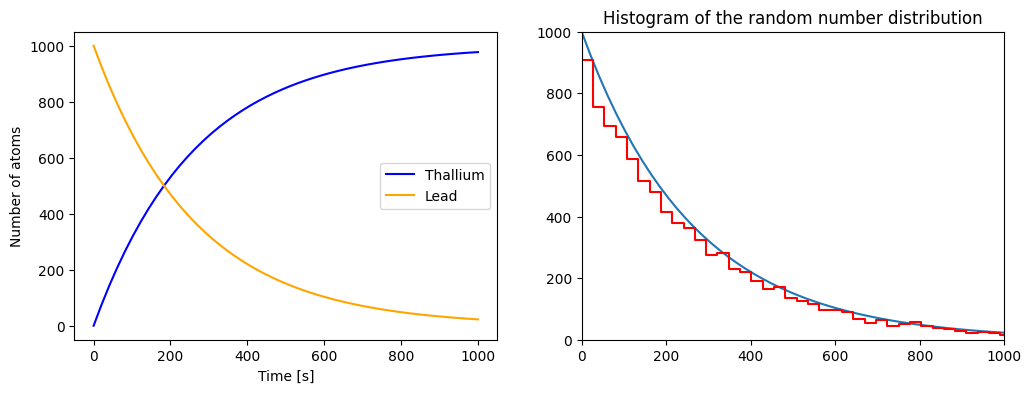

In [4]:
import math
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

tau = 3.052*60 #[s]
N = 1000 #number of Thallium atoms

#probability density function
def p(t, tau):
    return 1-2**(-t/tau)

#inverse CDF
def p_icdf(y, tau):
    res = []
    for el in y:
        res.append(-tau*math.log(1-el, 2))
    return np.array(res)

t = np.linspace(0, 1000)
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(t, N*p(t, tau), color='blue')
plt.plot(t, N*(1-p(t, tau)), color='orange')
plt.legend(['Thallium', 'Lead'])
plt.xlabel('Time [s]')
plt.ylabel('Number of atoms')

atoms = np.random.random(10000)
d_atoms = p_icdf(atoms, tau)
plt.subplot(122)
hist_values, hist_bins = np.histogram(d_atoms, bins='auto', density=False)
plt.plot(t, N*(1-p(t, tau)))
plt.step(hist_bins[:-1], hist_values, color='red')
plt.axis([0, 1000, 0, 1000])
plt.title('Histogram of the random number distribution')

2\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function: 

$$f(x) =\sin^2{\left( \frac{1}{1-x} \right)}$$

* Plot the function and compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate (hint: repeat the integral $N$ times, and from the distribution of the integrals take the mean value and the standard deviation, the latter rescaled by the appropriate factor)
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one.

Integral with MC method: 1.3442
The mean value is: 1.346268
The standard deviation is: 0.009770044831012818

Integral with mean value method: 1.3576224614348174
The standard deviation is: 0.006444717996553554


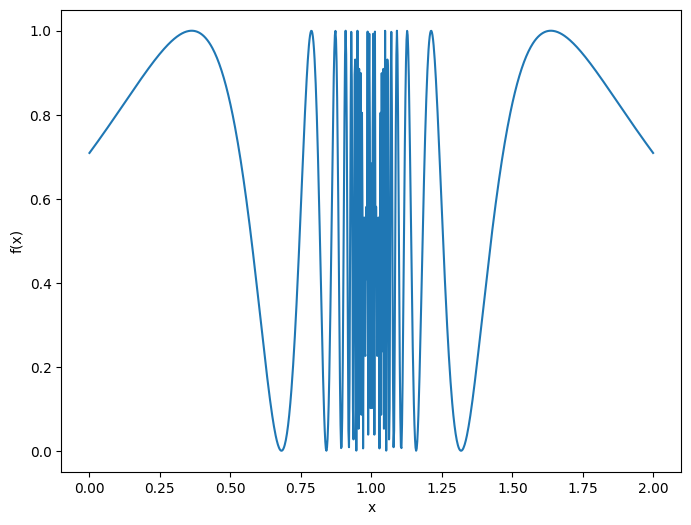

In [11]:
import math
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return (np.sin(1/(1-x)))**2

x = np.linspace(0.001, 1.999, 1000)
plt.figure(figsize=(8,6))
plt.plot(x, f(x))
plt.xlabel('x')
plt.ylabel('f(x)')


#Monte Carlo integration method and error analysis
a, b, h = 0, 1, 2
N = 10000
count = 0

def MC_integration(a, b, h, N, count):
    for i in range(N):
        x = h*np.random.random()
        y = (b-a)*np.random.random()
        if y < f(x): 
            count += 1
    return count/N*h*(b-a)

I = MC_integration(a, b, h, N, count)
print('Integral with MC method:', I)

I_err = np.array([MC_integration(a, b, h, N, count) for i in range(100)])
I_err_mean = I_err.mean()
I_err_std = I_err.std()
print('The mean value is:', I_err_mean)
print('The standard deviation is:', I_err_std)


#Mean value integration method
x_m = h*np.random.random(N)
y = np.array([f(x_m[j]) for j in range(N)])

I_mv = (h*np.sum(y))/N
print('\nIntegral with mean value method:', I_mv)

I_mv_std = h*np.std(y)/np.sqrt(N)
print('The standard deviation is:', I_mv_std)

3\. **Monte Carlo integration in high dimension**

* Compute the area of a circle of unit radius, by integrating the function:

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere.

In [7]:
import numpy as np

dim1 = 2

def f(x, y):
    if x**2 + y**2 <= 1:
        return 1
    else:
        return 0
    
a, b, h = -1, 1, 2
N = 10000
count = 0

def MC_integration(a, b, h, N, count):
    for i in range(N):
        x = h*np.random.random()
        y = (b-a)*np.random.random()
        if f(x, y) == 1: 
            count += 1
    return (count/N)*h*(b-a)

x = np.random.random(100)
y = np.random.random(100)
area = ((b-a)**dim1)*MC_integration(a, b, h, N, count)
print('The area of the circle is:', area)

#Generazlizetion at 10 dimensions
dim2 = 10

def mod_f(point):
    if np.sum(point**2) <= 1:
        return 1
    else:
        return 0

def MC_integration(a, b, N, count):
    for _ in range(N):
        point = a + (b - a) * np.random.rand(dim2)
        count += mod_f(point)
    return (count/N)*(b-a)**dim2

count2 = 0
volume = MC_integration(a, b, N, count2)
print('The volume of the 10 dimensional sphere is:', volume)


The area of the circle is: 3.1168
The volume of the 10 dimensional sphere is: 2.7648


4\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should expect a result around 0.84.

In [11]:
import numpy as np
import math

def f(x):
    return ((x**(-1/2))/(np.exp(x)+1))

def w(x):
    return 1/np.sqrt(x)

def integration(x, a, b):
    return 2*math.sqrt(b)-2*math.sqrt(a)

N = 100000
x = np.array([np.random.uniform(0, 1)**2 for _ in range(N)]) #WHY THE POWER OF TWO?
r = np.array([(f(x[i])/w(x[i])) for i in range(N)])

I = (np.sum(r)*integration(x, 0, 1))/N
print('\nIntegral with importance sampling method:', I)




Integral with mean value method: 0.8389736212079157
